Import all libraries and functions

In [26]:
from functions import *

Import the dataframe

In [27]:
df_reviews = pd.read_csv('../../data/cleaned/reviews.csv', encoding='utf-8', parse_dates=['creation_timestamp','answer_timestamp'] )
df_reviews = df_reviews.copy()

In [28]:
df_reviews.dtypes

review_id                     object
order_id                      object
score                          int64
title                         object
message                       object
creation_timestamp    datetime64[ns]
answer_timestamp      datetime64[ns]
review_unique_id              object
dtype: object

## Setup Portuguese words 

In [29]:
# Download Portuguese stopwords (ex: "o", "a", "os", "as", "de", "que", "em".)

setup_nltk()
portuguese_stopwords = get_portuguese_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [30]:
df_reviews['cleaned_review'], df_reviews['emojis'] = zip(*df_reviews['message'].apply(lambda x: clean_text(x, portuguese_stopwords)))

## Sentiment Analysis

#### Emoji Analysis

In [31]:
emoji_counts = df_reviews['emojis'].apply(lambda x: [c for c in x]).explode().value_counts()

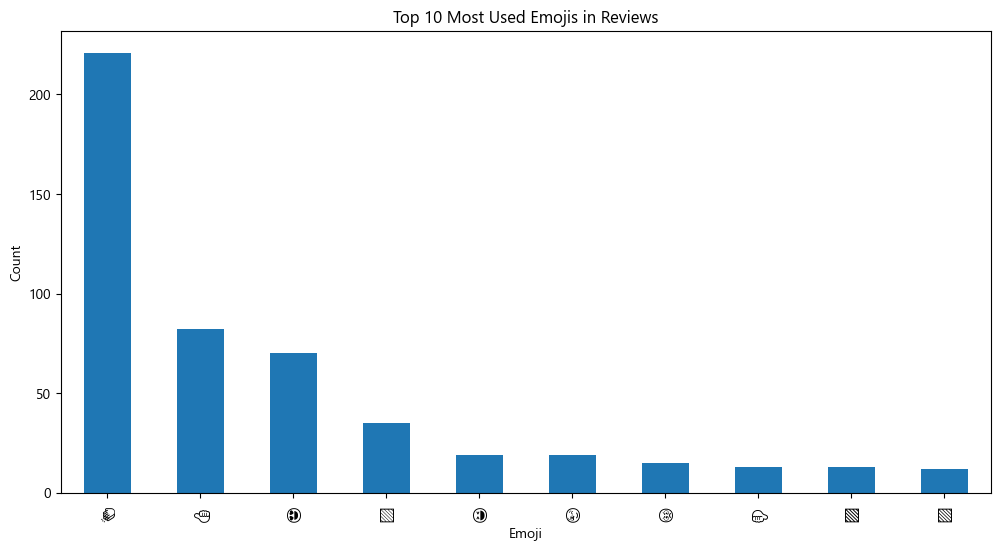

In [32]:
# Visualize emoji distribution

plt.figure(figsize=(12, 6))
emoji_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Used Emojis in Reviews')
plt.xlabel('Emoji')
plt.ylabel('Count')
plt.show()

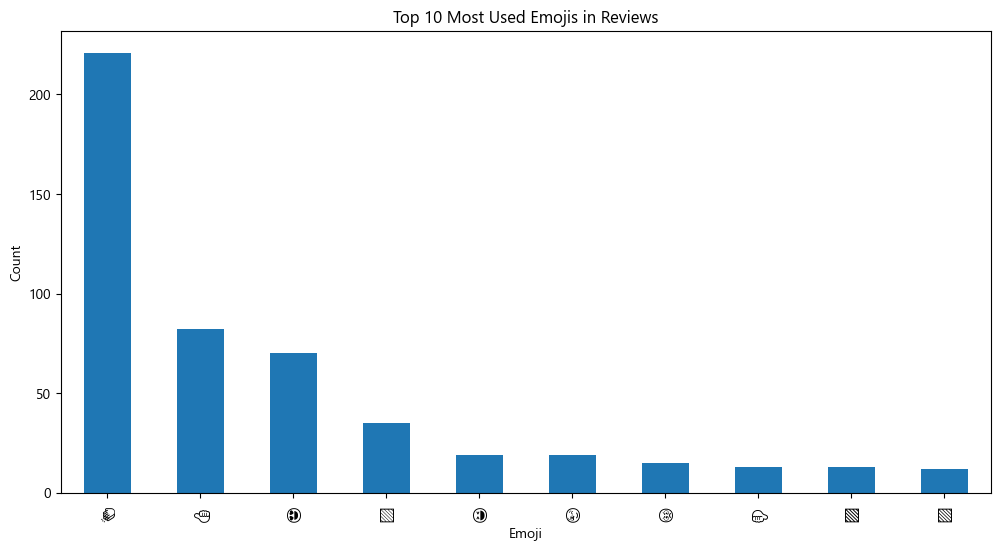

In [33]:
import matplotlib.pyplot as plt

# Set the global font to Segoe UI Emoji
plt.rcParams['font.family'] = 'Segoe UI Emoji'

# Plotting the emoji counts
plt.figure(figsize=(12, 6))
emoji_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Used Emojis in Reviews')
plt.xlabel('Emoji')
plt.ylabel('Count')
plt.show()

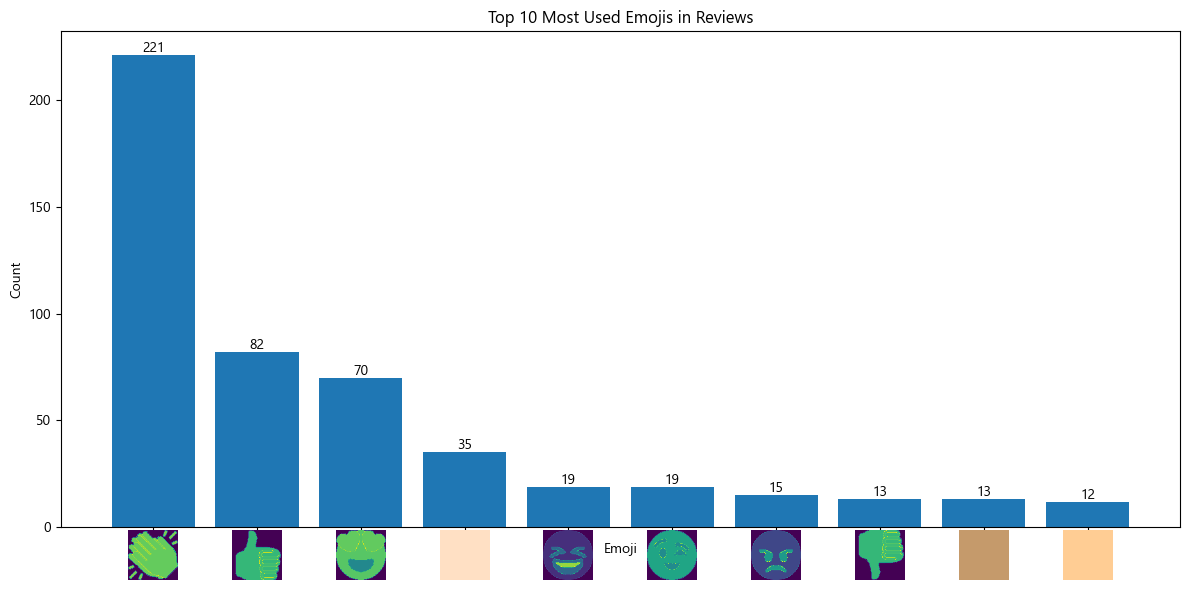

Top 10 emojis:
👏: 221
👍: 82
😍: 70
🏻: 35
😆: 19
😉: 19
😡: 15
👎: 13
🏽: 13
🏼: 12


In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import emoji

def get_emoji_image(emoji_char):
    # Check if it's a skin tone modifier
    if emoji_char in ['🏻', '🏼', '🏽', '🏾', '🏿']:
        return create_skin_tone_image(emoji_char)
    
    unicode_variations = [
        f'{ord(emoji_char):x}',
        f'{ord(emoji_char):x}-fe0f',
        f'{ord(emoji.emojize(emoji_char)):x}'
    ]
    
    for unicode in unicode_variations:
        url = f'https://github.com/twitter/twemoji/raw/master/assets/72x72/{unicode}.png'
        try:
            response = requests.get(url)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            return img
        except requests.exceptions.RequestException:
            print(f"Failed to fetch emoji image for {emoji_char} (Unicode: {unicode})")
    
    print(f"Could not find image for emoji {emoji_char}")
    return None

def create_skin_tone_image(skin_tone_char):
    # Create a simple colored square for skin tone modifiers
    color_map = {
        '🏻': (255, 224, 196),  # Light Skin Tone
        '🏼': (255, 205, 148),  # Medium-Light Skin Tone
        '🏽': (197, 154, 107),  # Medium Skin Tone
        '🏾': (141, 85, 36),    # Medium-Dark Skin Tone
        '🏿': (69, 52, 34)      # Dark Skin Tone
    }
    color = color_map.get(skin_tone_char, (255, 255, 255))
    img = Image.new('RGB', (72, 72), color)
    return img

# Assuming emoji_counts is your Series of emoji counts
top_emojis = emoji_counts.head(10)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top_emojis))
ax.bar(x, top_emojis.values)

ax.set_xticks(x)
ax.set_xticklabels([])  # Remove x-axis labels

for i, (emoji_char, count) in enumerate(top_emojis.items()):
    img = get_emoji_image(emoji_char)
    if img:
        im = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(im, (i, 0), xybox=(0, -20), frameon=False, 
                            xycoords='data', boxcoords="offset points", pad=0)
        ax.add_artist(ab)
    else:
        # Fallback: use text representation
        ax.text(i, -0.1, emoji_char, ha='center', va='top', fontsize=20)
    
    # Add count above the bar
    ax.text(i, top_emojis.values[i], str(count), ha='center', va='bottom')

plt.title('Top 10 Most Used Emojis in Reviews')
plt.xlabel('Emoji')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print the top emojis for debugging
print("Top 10 emojis:")
for emoji, count in top_emojis.items():
    print(f"{emoji}: {count}")

### Word frequency analysis

In [35]:
# Get most common words
all_words = ' '.join(df_reviews['cleaned_review']).split()
valid_words = [word for word in all_words if is_valid_word(word)]
word_counts = Counter(valid_words)
top_words_pt = word_counts.most_common(20)


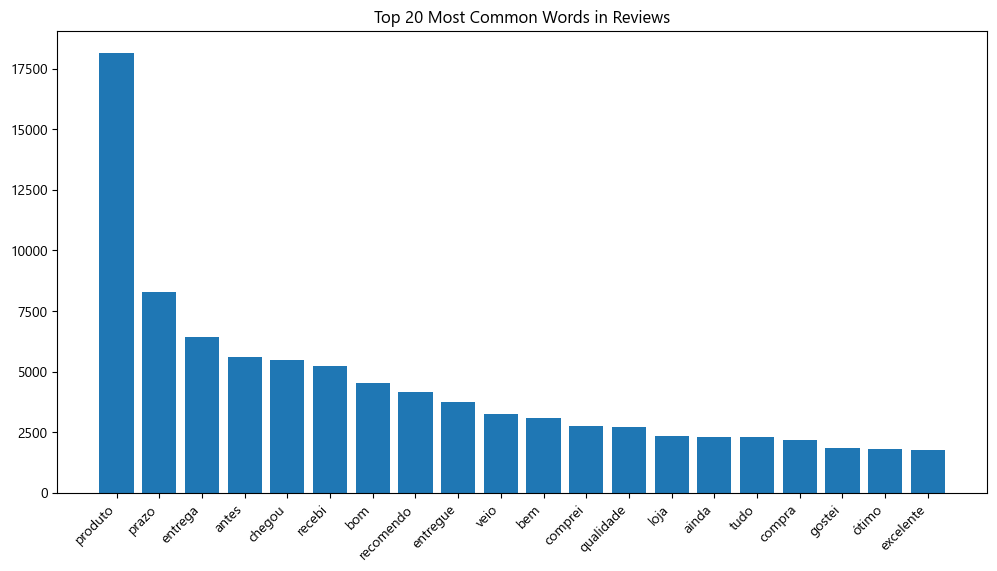

In [36]:
# Visualize
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words_pt))
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

Get the top words in English

In [37]:
top_words_pt = word_counts.most_common(20)
top_words_en = [(translate_to_english(word), count) for word, count in top_words_pt]

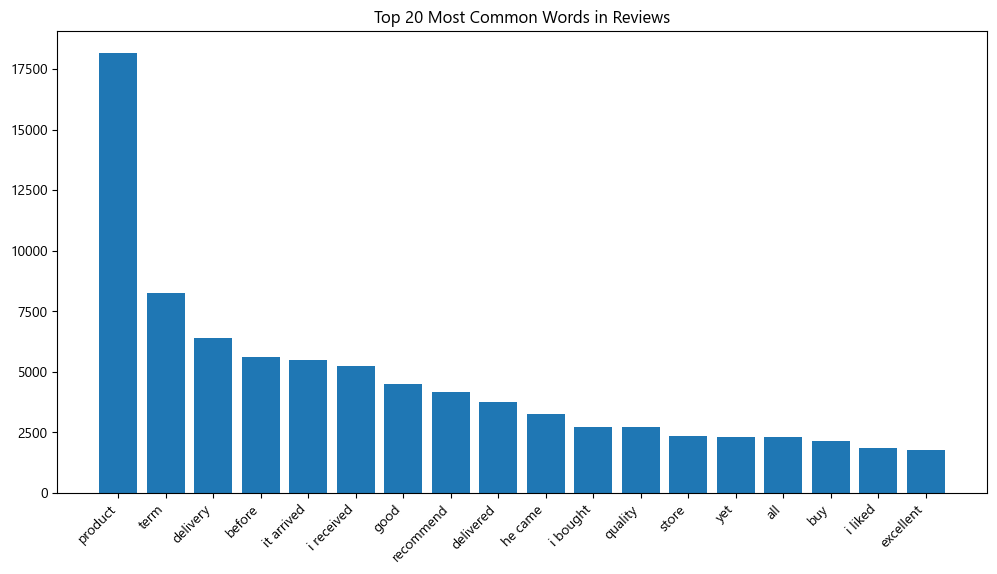

In [38]:
# Visualize
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words_en))
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [39]:
# Create DataFrame
df_top_words = pd.DataFrame({
    'portuguese': [word for word, _ in top_words_pt],
    'english': [word for word, _ in top_words_en],
    'count': [count for _, count in top_words_pt]
})

In [40]:
# Sort by count in descending order
df_top_words = df_top_words.sort_values('count', ascending=False).reset_index(drop=True)


Save to a new csv file

In [41]:
df_top_words.to_csv('../../data/cleaned/df_top_words.csv', index=False)

In [42]:
df_reviews.head(3)

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,


In [43]:
data_exploration(df_reviews)

Number of rows: 99224
Number of columns: 10
Number of duplicates: 0

Numerical Columns: Index(['score'], dtype='object')

Categorical Columns: Index(['review_id', 'order_id', 'title', 'message', 'review_unique_id',
       'cleaned_review', 'emojis'],
      dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,review_id,object,99224,0,98410
1,order_id,object,99224,0,98673
2,score,int64,99224,0,5
3,title,object,99224,0,4527
4,message,object,99224,0,36159
5,creation_timestamp,datetime64[ns],99224,0,636
6,answer_timestamp,datetime64[ns],99224,0,98248
7,review_unique_id,object,99224,0,99224
8,cleaned_review,object,99224,0,32686
9,emojis,object,99224,0,124


Run Hugging Face's API locally, otherwise, it will take 10 days to run.

In [44]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path) # run this code takes 5-8 s

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [45]:
df_sentiment = df_reviews.copy()

In [46]:
# df_sentiment['sentiment_task'] = df_sentiment['cleaned_review'].apply(lambda x: sentiment_task(x)[0]) # run 1000 samples takes 1 min. Run df_reviews takes 107 minutes

In [47]:
df_sentiment.head(3)

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,


In [48]:
# # Split the sentiment_task column to get the sentiment value
# df_sentiment['sentiment_label'] = df_sentiment['sentiment_task'].apply(lambda x: x['label'])
# df_sentiment['sentiment_score'] = df_sentiment['sentiment_task'].apply(lambda x: x['score'])

In [49]:
df_sentiment.head()

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,


Save to a new csv file

In [50]:
# df_sentiment.to_csv('../../data/cleaned/sentiment_analysis.csv')

In [52]:
# df_sentiment['sentiment_label'].value_counts()

#### Re-do sentiment analysis after drop '0'

In [53]:
df_reviews_without_0 = df_reviews[df_reviews['cleaned_review'] != '0'].reset_index()

In [54]:
df_reviews_without_0.drop(columns='index')

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,8670d52e15e00043ae7de4c01cc2fe06_b9bf720beb4ab...,aparelho eficiente site marca aparelho impress...,
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,0,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,4b49719c8a200003f700d3d986ea1a19_9d6f15f95d01e...,pouco travandopelo valor ta boa,
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01,3948b09f7c818e2d86c9a546758b2335_e51478e7e277a...,vendedor confiável produto ok entrega antes prazo,
...,...,...,...,...,...,...,...,...,...,...
40971,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,0,para este produto recebi de acordo com a compr...,2017-11-29,2017-11-30 15:52:51,98fffa80dc9acbde7388bef1600f3b15_d398e9c82363c...,produto recebi acordo compra realizada,
40972,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,0,Entregou dentro do prazo. O produto chegou em ...,2018-02-07,2018-02-19 19:47:23,df5fae90e85354241d5d64a8955b2b09_509b86c65fe4e...,entregou dentro prazo produto chegou condições...,
40973,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,0,"O produto não foi enviado com NF, não existe v...",2018-05-19,2018-05-20 21:51:06,a709d176f59bc3af77f4149c96bae357_d5cb12269711b...,produto enviado nf existe venda nf certeza fic...,
40974,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,0,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43,b3de70c89b1510c4cd3d0649fd302472_55d4004744368...,excelente mochila entrega super rápida super r...,


In [55]:
df_sentiment_without_0 = df_reviews_without_0.copy()

In [56]:
# df_sentiment_without_0['sentiment_task'] = df_sentiment_without_0['cleaned_review'].apply(lambda x: sentiment_task(x)[0]) # run this takes 54 minutes

In [57]:
df_sentiment_without_0.head(3)

,index,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
1,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,
2,9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,8670d52e15e00043ae7de4c01cc2fe06_b9bf720beb4ab...,aparelho eficiente site marca aparelho impress...,


In [58]:
# # Split the sentiment_task column to get the sentiment value
# df_sentiment_without_0['sentiment_label'] = df_sentiment_without_0['sentiment_task'].apply(lambda x: x['label'])
# df_sentiment_without_0['sentiment_score'] = df_sentiment_without_0['sentiment_task'].apply(lambda x: x['score'])

In [59]:
df_sentiment_without_0 = df_sentiment_without_0.drop(columns='index')

In [60]:
df_sentiment_without_0.head(3)

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,8670d52e15e00043ae7de4c01cc2fe06_b9bf720beb4ab...,aparelho eficiente site marca aparelho impress...,


Save to a new csv file

In [61]:
# df_sentiment_without_0.to_csv('../../data/cleaned/sentiment_analysis_without_0.csv')

In [63]:
# df_sentiment_without_0['sentiment_label'].value_counts()

In [65]:
# df_sentiment[df_sentiment['cleaned_review'] != '0']['sentiment_label'].value_counts()

## Emotion Detection

In [66]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base") # run this takes 49 s

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [67]:
from transformers import pipeline
model_path = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True) # run this takes 0.5 s

c:\Users\Gebruiker\anaconda3\envs\env_project_final\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [68]:
df_sentiment = df_sentiment.copy()

In [69]:
df_sentiment.head(3)

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,


In [70]:
df_samples = df_sentiment.sample(100)

In [71]:
df_samples['emotion_task'] = df_samples['cleaned_review'].apply(lambda x: classifier(x)[0]) # for 100 rows, it takes 4 s

In [72]:
# df_sentiment['emotion_task'] = df_sentiment['cleaned_review'].apply(lambda x: classifier(x)[0])  # run this takes 64 min 43 s

In [73]:
df_sentiment.head(3)

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,


In [75]:
# df_sentiment['emotion_task'][0]

In [76]:
# df_sentiment['emotion_label'] = df_sentiment['emotion_task'].apply(lambda x: max(x, key=lambda y: y['score'])['label'])
# df_sentiment['emotion_score'] = df_sentiment['emotion_task'].apply(lambda x: max(x, key=lambda y: y['score'])['score'])

In [77]:
df_sentiment.head()

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-18,2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40_73fc7af87114b...,0,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-10,2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde_a548910a1c614...,0,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-17,2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a...,0,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,


Save to sentiment_analysis.csv 

In [78]:
# df_sentiment.to_csv('../../data/cleaned/sentiment_analysis.csv', index=False)

In [80]:
#df_sentiment['emotion_label'].value_counts()

In [82]:
# df_sentiment[df_sentiment['cleaned_review'] != '0']['emotion_label'].value_counts()

#### Re-do emotion detection for cleaned_review != '0'

In [83]:
df_sentiment_without_0 = df_sentiment[df_sentiment['cleaned_review'] != '0'].copy()

In [84]:
df_sentiment_without_0.shape

(40976, 10)

In [85]:
# df_sentiment_without_0['emotion_task'] = df_sentiment_without_0['cleaned_review'].apply(lambda x: classifier(x)[0]) # run this takes 35 min

In [86]:
# df_sentiment_without_0['emotion_label'] = df_sentiment_without_0['emotion_task'].apply(lambda x: max(x, key=lambda y: y['score'])['label'])
# df_sentiment_without_0['emotion_score'] = df_sentiment_without_0['emotion_task'].apply(lambda x: max(x, key=lambda y: y['score'])['score'])

In [87]:
df_sentiment_without_0

,review_id,order_id,score,title,message,creation_timestamp,answer_timestamp,review_unique_id,cleaned_review,emojis
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,0,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e_658677c97b385...,recebi bem antes prazo estipulado,
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283f...,parabéns lojas lannister adorei comprar intern...,
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,8670d52e15e00043ae7de4c01cc2fe06_b9bf720beb4ab...,aparelho eficiente site marca aparelho impress...,
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,0,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,4b49719c8a200003f700d3d986ea1a19_9d6f15f95d01e...,pouco travandopelo valor ta boa,
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01,3948b09f7c818e2d86c9a546758b2335_e51478e7e277a...,vendedor confiável produto ok entrega antes prazo,
...,...,...,...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,0,para este produto recebi de acordo com a compr...,2017-11-29,2017-11-30 15:52:51,98fffa80dc9acbde7388bef1600f3b15_d398e9c82363c...,produto recebi acordo compra realizada,
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,0,Entregou dentro do prazo. O produto chegou em ...,2018-02-07,2018-02-19 19:47:23,df5fae90e85354241d5d64a8955b2b09_509b86c65fe4e...,entregou dentro prazo produto chegou condições...,
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,0,"O produto não foi enviado com NF, não existe v...",2018-05-19,2018-05-20 21:51:06,a709d176f59bc3af77f4149c96bae357_d5cb12269711b...,produto enviado nf existe venda nf certeza fic...,
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,0,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43,b3de70c89b1510c4cd3d0649fd302472_55d4004744368...,excelente mochila entrega super rápida super r...,


Save to csv file.

In [88]:
# df_sentiment_without_0.to_csv('../../data/cleaned/sentiment_analysis_without_0.csv', index=False)

## Create a words cloud

In [89]:
# Combine all reviews into a single string
text = ' '.join(df_reviews['cleaned_review'])

In [90]:
# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

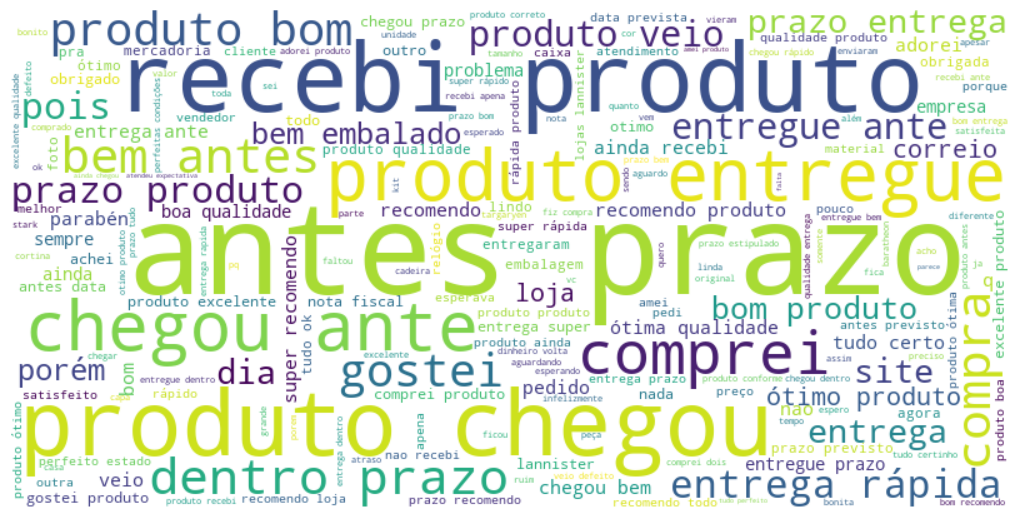

In [91]:
# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

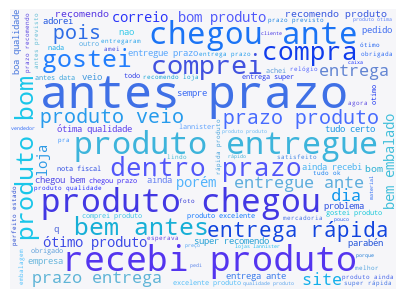

In [92]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom color function to generate shades of blue
def blue_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#%02x%02x%02x" % (random_state.randint(13, 100),  # R
                              random_state.randint(42, 200),  # G
                              random_state.randint(208, 255)) # B

# Create and generate a word cloud image
wordcloud = WordCloud(width=386, height=280, 
                      background_color='#F6F6F9',
                      color_func=blue_color_func,
                      max_words=100).generate(text)

# Display the generated image
plt.figure(figsize=(386/100, 280/100))  # Convert pixels to inches
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

English version

In [93]:
# words = text.split()

In [94]:
# # Load model directly
# from transformers import MarianMTModel, MarianTokenizer


# model_name = "Helsinki-NLP/opus-mt-pt-en"
# tokenizer = MarianTokenizer.from_pretrained(model_name)
# model = MarianMTModel.from_pretrained(model_name)
# translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))

In [95]:
# pipe = pipeline("translation", model="facebook/nllb-200-distilled-600M")

In [96]:
df_samples = df_sentiment_without_0.sample(100)

In [97]:
# df_samples['messages_EN'] = df_samples['cleaned_review'].apply(lambda x: pipe(x)[0]) # for 100 rows, it takes 

## Import csv files to MySQL

Connect with MySQL

In [98]:
# Load environment variables from .env file
load_dotenv()

# Access the password
password = os.getenv('mySQL_password')

database = "mydb"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/'+ database
engine = create_engine(connection_string)

In [99]:
df_sentiment.columns

Index(['review_id', 'order_id', 'score', 'title', 'message',
       'creation_timestamp', 'answer_timestamp', 'review_unique_id',
       'cleaned_review', 'emojis'],
      dtype='object')

In [100]:
df_sentiment.dtypes

review_id                     object
order_id                      object
score                          int64
title                         object
message                       object
creation_timestamp    datetime64[ns]
answer_timestamp      datetime64[ns]
review_unique_id              object
cleaned_review                object
emojis                        object
dtype: object

In [101]:
df_sentiment = pd.read_csv('../../data/cleaned/sentiment_analysis.csv')
df_sentiment.to_sql('sentiment_analysis', con=engine, index=False, if_exists='append')

IntegrityError: (pymysql.err.IntegrityError) (1062, "Duplicate entry '7bc2406110b926393aa56f80a40eba40_73fc7af87114b39712e6da79b0a377e' for key 'sentiment_analysis.PRIMARY'")
[SQL: INSERT INTO sentiment_analysis (review_id, order_id, score, title, message, creation_timestamp, answer_timestamp, review_unique_id, cleaned_review, emojis, sentiment_task, sentiment_label, sentiment_score, emotion_task, emotion_label, emotion_score) VALUES (%(review_id)s, %(order_id)s, %(score)s, %(title)s, %(message)s, %(creation_timestamp)s, %(answer_timestamp)s, %(review_unique_id)s, %(cleaned_review)s, %(emojis)s, %(sentiment_task)s, %(sentiment_label)s, %(sentiment_score)s, %(emotion_task)s, %(emotion_label)s, %(emotion_score)s)]
[parameters: [{'review_id': '7bc2406110b926393aa56f80a40eba40', 'order_id': '73fc7af87114b39712e6da79b0a377eb', 'score': 4, 'title': '0', 'message': '0', 'creation_timestamp': '2018-01-18 00:00:00', 'answer_timestamp': '2018-01-18 21:46:59', 'review_unique_id': '7bc2406110b926393aa56f80a40eba40_73fc7af87114b39712e6da79b0a377eb', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': '80e641a11e56f04c1ad469d5645fdfde', 'order_id': 'a548910a1c6147796b98fdf73dbeba33', 'score': 5, 'title': '0', 'message': '0', 'creation_timestamp': '2018-03-10 00:00:00', 'answer_timestamp': '2018-03-11 03:05:13', 'review_unique_id': '80e641a11e56f04c1ad469d5645fdfde_a548910a1c6147796b98fdf73dbeba33', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': '228ce5500dc1d8e020d8d1322874b6f0', 'order_id': 'f9e4b658b201a9f2ecdecbb34bed034b', 'score': 5, 'title': '0', 'message': '0', 'creation_timestamp': '2018-02-17 00:00:00', 'answer_timestamp': '2018-02-18 14:36:24', 'review_unique_id': '228ce5500dc1d8e020d8d1322874b6f0_f9e4b658b201a9f2ecdecbb34bed034b', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': 'e64fb393e7b32834bb789ff8bb30750e', 'order_id': '658677c97b385a9be170737859d3511b', 'score': 5, 'title': '0', 'message': 'Recebi bem antes do prazo estipulado.', 'creation_timestamp': '2017-04-21 00:00:00', 'answer_timestamp': '2017-04-21 22:02:06', 'review_unique_id': 'e64fb393e7b32834bb789ff8bb30750e_658677c97b385a9be170737859d3511b', 'cleaned_review': 'recebi bem antes prazo estipulado', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.6480153799057007}", 'sentiment_label': 'neutral', 'sentiment_score': 0.6480153799057007, 'emotion_task': "[{'label': 'anger', 'score': 0.1914350539445877}, {'label': 'disgust', 'score': 0.024942832067608833}, {'label': 'fear', 'score': 0.11114469915628433 ... (56 characters truncated) ... l': 'neutral', 'score': 0.5652716159820557}, {'label': 'sadness', 'score': 0.05162613466382027}, {'label': 'surprise', 'score': 0.04299740865826607}]", 'emotion_label': 'neutral', 'emotion_score': 0.5652716159820557}, {'review_id': 'f7c4243c7fe1938f181bec41a392bdeb', 'order_id': '8e6bfb81e283fa7e4f11123a3fb894f1', 'score': 5, 'title': '0', 'message': 'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa', 'creation_timestamp': '2018-03-01 00:00:00', 'answer_timestamp': '2018-03-02 10:26:53', 'review_unique_id': 'f7c4243c7fe1938f181bec41a392bdeb_8e6bfb81e283fa7e4f11123a3fb894f1', 'cleaned_review': 'parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa', 'emojis': None, 'sentiment_task': "{'label': 'positive', 'score': 0.8807154893875122}", 'sentiment_label': 'positive', 'sentiment_score': 0.8807154893875122, 'emotion_task': "[{'label': 'anger', 'score': 0.11821410059928894}, {'label': 'disgust', 'score': 0.0397556871175766}, {'label': 'fear', 'score': 0.1939965933561325}, ... (57 characters truncated) ... : 'neutral', 'score': 0.32229694724082947}, {'label': 'sadness', 'score': 0.09466678649187088}, {'label': 'surprise', 'score': 0.037645164877176285}]", 'emotion_label': 'neutral', 'emotion_score': 0.3222969472408294}, {'review_id': '15197aa66ff4d0650b5434f1b46cda19', 'order_id': 'b18dcdf73be66366873cd26c5724d1dc', 'score': 1, 'title': '0', 'message': '0', 'creation_timestamp': '2018-04-13 00:00:00', 'answer_timestamp': '2018-04-16 00:39:37', 'review_unique_id': '15197aa66ff4d0650b5434f1b46cda19_b18dcdf73be66366873cd26c5724d1dc', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': '07f9bee5d1b850860defd761afa7ff16', 'order_id': 'e48aa0d2dcec3a2e87348811bcfdf22b', 'score': 5, 'title': '0', 'message': '0', 'creation_timestamp': '2017-07-16 00:00:00', 'answer_timestamp': '2017-07-18 19:30:34', 'review_unique_id': '07f9bee5d1b850860defd761afa7ff16_e48aa0d2dcec3a2e87348811bcfdf22b', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': '7c6400515c67679fbee952a7525281ef', 'order_id': 'c31a859e34e3adac22f376954e19b39d', 'score': 5, 'title': '0', 'message': '0', 'creation_timestamp': '2018-08-14 00:00:00', 'answer_timestamp': '2018-08-14 21:36:06', 'review_unique_id': '7c6400515c67679fbee952a7525281ef_c31a859e34e3adac22f376954e19b39d', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}  ... displaying 10 of 99224 total bound parameter sets ...  {'review_id': '1adeb9d84d72fe4e337617733eb85149', 'order_id': '7725825d039fc1f0ceb7635e3f7d9206', 'score': 4, 'title': '0', 'message': '0', 'creation_timestamp': '2018-07-01 00:00:00', 'answer_timestamp': '2018-07-02 12:59:13', 'review_unique_id': '1adeb9d84d72fe4e337617733eb85149_7725825d039fc1f0ceb7635e3f7d9206', 'cleaned_review': '0', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.47364354133605957}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4736435413360595, 'emotion_task': "[{'label': 'anger', 'score': 0.03143719956278801}, {'label': 'disgust', 'score': 0.02776300348341465}, {'label': 'fear', 'score': 0.01580763049423694 ... (60 characters truncated) ... ': 'neutral', 'score': 0.8145654797554016}, {'label': 'sadness', 'score': 0.04942969232797623}, {'label': 'surprise', 'score': 0.055055052042007446}]", 'emotion_label': 'neutral', 'emotion_score': 0.8145654797554016}, {'review_id': 'efe49f1d6f951dd88b51e6ccd4cc548f', 'order_id': '90531360ecb1eec2a1fbb265a0db0508', 'score': 1, 'title': '0', 'message': 'meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga', 'creation_timestamp': '2017-07-03 00:00:00', 'answer_timestamp': '2017-07-03 21:01:49', 'review_unique_id': 'efe49f1d6f951dd88b51e6ccd4cc548f_90531360ecb1eec2a1fbb265a0db0508', 'cleaned_review': 'produto chegou ja devolver pois defeito segurar carga', 'emojis': None, 'sentiment_task': "{'label': 'neutral', 'score': 0.4856630265712738}", 'sentiment_label': 'neutral', 'sentiment_score': 0.4856630265712738, 'emotion_task': "[{'label': 'anger', 'score': 0.30980098247528076}, {'label': 'disgust', 'score': 0.037069518119096756}, {'label': 'fear', 'score': 0.2399704158306121 ... (59 characters truncated) ... ': 'neutral', 'score': 0.27564406394958496}, {'label': 'sadness', 'score': 0.05843508988618851}, {'label': 'surprise', 'score': 0.02719101682305336}]", 'emotion_label': 'anger', 'emotion_score': 0.3098009824752807}]]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [ ]:
df_top_words = pd.read_csv('../../data/cleaned/df_top_words.csv')
df_top_words.to_sql('top_words', con=engine, index=False, if_exists='append')

20